# Imports

In [1]:
import sys
import json
import string
import itertools
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
sns.set()

[nltk_data] Error loading stopwords: <urlopen error unknown url type:
[nltk_data]     https>


In [2]:
import pprint
import jsonpickle
import pandas as pd

pd.set_option('display.max_columns', 100)

In [3]:
def read_file(file_name='data.txt'):
    """ Example of file name 'data.txt' """
    with open(file_name, "r") as fichier:
        file = fichier.read()
    return file

# Users info

In [4]:
path = '../data/users_twitter_data.txt'
users = read_file(path).split('\n')
print(len(users))

4


In [5]:
user = jsonpickle.decode(users[1])
print(user['description'])

Ismail Mebsout, an engineer and a data scientist @ Capgemini Invent.
Passionate about Machine Learning and its various applications


In [6]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(user)

{   'contributors_enabled': False,
    'created_at': 'Mon Mar 09 11:13:22 +0000 2020',
    'default_profile': True,
    'default_profile_image': False,
    'description': 'Ismail Mebsout, an engineer and a data scientist @ '
                   'Capgemini Invent.\n'
                   'Passionate about Machine Learning and its various '
                   'applications',
    'entities': {'description': {'urls': []}},
    'favourites_count': 1,
    'follow_request_sent': None,
    'followers_count': 12,
    'following': None,
    'friends_count': 93,
    'geo_enabled': False,
    'has_extended_profile': False,
    'id': 1236973292944310272,
    'id_str': '1236973292944310272',
    'is_translation_enabled': False,
    'is_translator': False,
    'lang': None,
    'listed_count': 0,
    'location': '',
    'name': 'Mebsout Ismail',
    'notifications': None,
    'profile_background_color': 'F5F8FA',
    'profile_background_image_url': None,
    'profile_background_image_url_https': None,
 

# Tweets Loading

In [7]:
path = '../data/tweets.txt'
with open(path, 'rb') as pfile:
    tl = pfile.read()
tl = read_file(path)
tweets = tl.split('\n')
print(len(tweets))

501


In [8]:
def get_tweet_info(tweet):
    tweet_dict = {}
    tmp = jsonpickle.decode(tweet)
    tweet_dict['date'] = tmp['created_at']
    tweet_dict['id_tweet'] = tmp['id']
    tweet_dict['hashtag'] = [i['text'] for i in tmp['entities']['hashtags']]
    tweet_dict['text'] = tmp['full_text']
    tweet_dict['location'] = tmp['user']['location']
    tweet_dict['id_user'] = tmp['user']['id']
    
    return tweet_dict

In [9]:
df_list = []
for tweet in tweets[:-1]:
    df_list.append(get_tweet_info(tweet))
df = pd.DataFrame(df_list)

In [10]:
df[['text']].head()

,text
0,Demain 23H je serai en live sur https://t.co/F...
1,Bonjour twitter ☕\nBon mardi à tous 🌸💐\n\n#ma...
2,"Le #confinement se passe ""globalement bien"" en..."
3,👍#vélo #confinement « Ne sont réglementés que ...
4,Je trouve que la gestion du #confinement en Fr...


# Tweets Processing

In [11]:
# Preparing transformations for preprocessing function
caracters_to_remove = list(string.punctuation)
transformation_car_dict = {initial:" " for initial in caracters_to_remove}

with_accent = ['é', 'è', 'ê', 'à', 'ù', 'ç', 'ô', 'î']
without_accent = ['e', 'e', 'e', 'a', 'u', 'c', 'o', 'i']
transformation_accent_dict = {before:after for before, after in zip(with_accent, without_accent)}

stopW = stopwords.words('french') + ['htttp', 'https']


# Preprocessing function to apply to the content column
def preprocessing(review):
  
    # Tokenization
    tokens = word_tokenize(review)
    
    # Deleting words with  only one caracter
    tokens = [token for token in tokens if len(token)>2]
    
    # stopwords + lowercase
    tokens = [token.lower() for token in tokens if token.lower() not in stopW]   
    
    # Removing accents
    tokens = [token.translate(str.maketrans(transformation_accent_dict)) for token in tokens]
    
    # Deleting specific caracters
    tokens = [token.translate(str.maketrans(transformation_car_dict)) for token in tokens]
    
    
    return tokens
  

# Creating a new column swith tokenized reviews
tokenized = df['text'].dropna().apply(preprocessing)

In [12]:
pd.DataFrame(tokenized).head()

,text
0,"[demain, 23h, live, t co fop0e7b52l, bout, m..."
1,"[bonjour, twitter, bon, mardi, tous, mardicons..."
2,"[confinement, passe, globalement, bien, france..."
3,"[velo, confinement, reglementes, motifs, depla..."
4,"[trouve, gestion, confinement, france, petit, ..."


In [13]:
# Preparing tokens for wordcloud
merged = list(itertools.chain(*tokenized.tolist()))
df_token = pd.Series(merged)
wordcloud_dict = df_token.value_counts().head(500).to_dict()

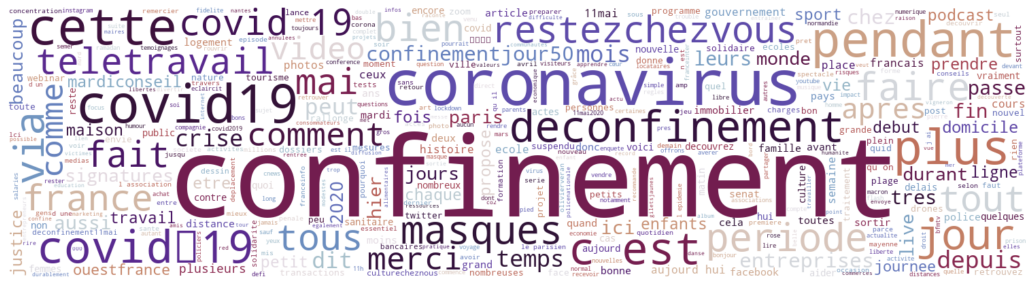

In [14]:
# Make wordcould
wordcloud = WordCloud(height=400, width=1500, background_color="white", colormap='twilight_shifted', max_words=400) #, mask=hotel_mask)
wordcloud.generate_from_frequencies(frequencies=wordcloud_dict)

# Plot it
plt.figure(figsize=(20,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment analysis

In [15]:
def get_sentiment(text):
    blob = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    return blob.sentiment

In [16]:
df['sentiment'] = df['text'].apply(get_sentiment)
df['sentiment_1'] = df['sentiment'].apply(lambda x:x[0])
df['sentiment_2'] = df['sentiment'].apply(lambda x:x[1])
df['datetime'] = pd.to_datetime(df['date'])

In [17]:
df.head(3)

,date,hashtag,id_tweet,id_user,location,text,sentiment,sentiment_1,sentiment_2,datetime
0,Tue May 05 08:33:01 +0000 2020,[confinement],1257589100242243584,741181788,paris,Demain 23H je serai en live sur https://t.co/F...,"(0.055, 0.075)",0.055,0.075,2020-05-05 08:33:01+00:00
1,Tue May 05 08:32:49 +0000 2020,"[mardiconseil, mardi, jour50, confinement, mus...",1257589049797292033,955492906466496512,Occitanie,Bonjour twitter ☕\nBon mardi à tous 🌸💐\n\n#ma...,"(0.45999999999999996, 0.39999999999999997)",0.460,0.400,2020-05-05 08:32:49+00:00
2,Tue May 05 08:32:45 +0000 2020,[confinement],1257589035519877120,542878994,@ade_StGermain : en secours,"Le #confinement se passe ""globalement bien"" en...","(-0.05499999999999999, 0.24999999999999997)",-0.055,0.250,2020-05-05 08:32:45+00:00


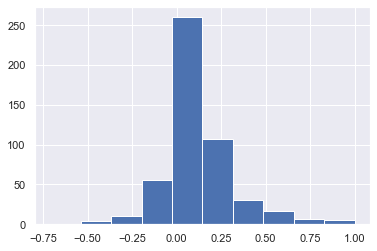

In [18]:
df.sentiment_1.hist()
_ = plt.plot()

In [19]:
print(df[df['sentiment_1']<-0.5]['text'].iloc[0])

Mauvaise idée ?

#confinement #deconfinement #coronavirus #ecole #francegall #dessin #bd #presse #quelbordel #viedapres https://t.co/lpXGmd6YiZ


/Users/thibaud/.local/share/virtualenvs/Breast_cancer-etG_JQXg/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


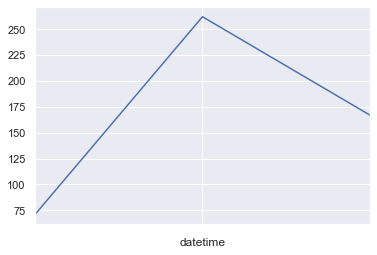

In [20]:
df.set_index('datetime').resample('H').count()['id_tweet'].plot()
_ = plt.show()

In [21]:
# Get a Series with all hashtags
hashtag_list = df['hashtag'].apply(lambda x:[i.lower() for i in x]).tolist()
hashtag_flat_list = [item for sublist in hashtag_list for item in sublist]
tmp = pd.Series(hashtag_flat_list)


# Count hashtags frequency
reduce_covid = lambda x: 'covid' if (('covid' in str(x) or ('corona' in str(x)))) else x
tmp = tmp.apply(reduce_covid)

In [22]:
# Display most frequent hashtags
tmp = tmp.value_counts()
tmp[tmp> 10]

confinement          501
covid                201
restezchezvous        24
deconfinement         17
confinementjour50     15
masques               13
france                11
mardiconseil          11
dtype: int64